# Forecasting of Phase Evolution (LSTM model)
#### * data from a scale free network

### Import Libraries

In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint        # for saving models
from tensorflow.keras.losses import MeanSquaredError          # loss function
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### Initial values

In [2]:
# Coupling value of Kuramoto model network
coupling=30        # this coupling refers to a scale free network
# List of window sizes to be used for training
window_sizes = [2,5]
# Number of epochs for training                              
n_epochs= 2       

### Read data file

In [3]:
my_csv = Path(f"./Data/SF_J={coupling}.csv")
df = pd.read_csv(my_csv.resolve(), sep=',')

In [4]:
# Select the first theta column and initialize phase_df with it
phase_df = df[f'theta{1}']

# Loop through the rest of the theta columns
for i in range(1, len(df.columns)):
    # Concatenate each subsequent theta column to phase_df along the columns axis
    phase_df = pd.concat([df[f'theta{i+1}'], phase_df], axis=1)

phase_df.head()

,theta60,theta59,theta58,theta57,theta56,theta55,theta54,theta53,theta52,theta51,...,theta10,theta9,theta8,theta7,theta6,theta5,theta4,theta3,theta2,theta1
0,1.94364,0.750206,-2.44708,-2.79573,1.95417,-2.50178,2.43684,-1.64878,1.20787,0.882270,...,-1.20244,-0.500704,3.05680,0.654684,-1.86303,2.92221,-1.67263,-0.404539,1.62465,0.730019
1,1.93055,0.776329,-2.44754,-2.78252,1.92690,-2.49208,2.41273,-1.61354,1.16075,0.868121,...,-1.20183,-0.507533,3.03503,0.647047,-1.83676,2.92051,-1.65316,-0.427725,1.62349,0.691659
2,1.91748,0.802004,-2.44789,-2.76937,1.89958,-2.48249,2.38877,-1.57853,1.11350,0.854063,...,-1.20125,-0.514358,3.01367,0.639079,-1.81054,2.91865,-1.63363,-0.450725,1.62211,0.653131
3,1.90441,0.827240,-2.44813,-2.75626,1.87222,-2.47303,2.36494,-1.54377,1.06613,0.840094,...,-1.20071,-0.521175,2.99276,0.630786,-1.78438,2.91662,-1.61405,-0.473529,1.62052,0.614455
4,1.89135,0.852049,-2.44826,-2.74320,1.84481,-2.46368,2.34125,-1.50923,1.01870,0.826215,...,-1.20021,-0.527982,2.97231,0.622176,-1.75828,2.91443,-1.59442,-0.496123,1.61871,0.575653


In [5]:
#reverse  theta60 to theta1
phase_df=phase_df[phase_df.columns[::-1]]
phase_df

,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,theta9,theta10,...,theta51,theta52,theta53,theta54,theta55,theta56,theta57,theta58,theta59,theta60
0,0.730019,1.62465,-0.404539,-1.672630,2.92221,-1.86303,0.654684,3.05680,-0.500704,-1.20244,...,0.882270,1.20787,-1.64878,2.43684,-2.50178,1.95417,-2.795730,-2.447080,0.750206,1.94364
1,0.691659,1.62349,-0.427725,-1.653160,2.92051,-1.83676,0.647047,3.03503,-0.507533,-1.20183,...,0.868121,1.16075,-1.61354,2.41273,-2.49208,1.92690,-2.782520,-2.447540,0.776329,1.93055
2,0.653131,1.62211,-0.450725,-1.633630,2.91865,-1.81054,0.639079,3.01367,-0.514358,-1.20125,...,0.854063,1.11350,-1.57853,2.38877,-2.48249,1.89958,-2.769370,-2.447890,0.802004,1.91748
3,0.614455,1.62052,-0.473529,-1.614050,2.91662,-1.78438,0.630786,2.99276,-0.521175,-1.20071,...,0.840094,1.06613,-1.54377,2.36494,-2.47303,1.87222,-2.756260,-2.448130,0.827240,1.90441
4,0.575653,1.61871,-0.496123,-1.594420,2.91443,-1.75828,0.622176,2.97231,-0.527982,-1.20021,...,0.826215,1.01870,-1.50923,2.34125,-2.46368,1.84481,-2.743200,-2.448260,0.852049,1.89135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39997,2.751460,-1.09954,2.255890,0.540663,-2.52389,2.00822,3.065630,-1.77015,-0.761536,-2.74121,...,-2.438100,-1.58274,1.62028,3.10063,2.41791,-1.64082,-0.588713,0.672763,-2.566420,-1.75338
39998,2.720420,-1.10655,2.244940,0.554471,-2.53424,2.04300,3.054620,-1.78511,-0.754975,-2.73549,...,-2.453230,-1.61338,1.65895,3.07044,2.44102,-1.66710,-0.574241,0.681249,-2.544510,-1.76664
39999,2.690100,-1.11350,2.234220,0.568216,-2.54477,2.07736,3.043750,-1.80047,-0.748327,-2.72983,...,-2.468350,-1.64431,1.69769,3.04044,2.46385,-1.69315,-0.559695,0.689550,-2.522840,-1.77990
40000,2.660510,-1.12038,2.223730,0.581902,-2.55547,2.11127,3.033010,-1.81623,-0.741592,-2.72425,...,-2.483480,-1.67553,1.73650,3.01064,2.48636,-1.71897,-0.545072,0.697666,-2.501400,-1.79317


### Create inputs and labels

In [6]:
def df_to_X_y(df, window_size):
  # Converts the DataFrame to an array
  df_as_np = df.to_numpy()
  # Initialize empty lists to hold the input sequences (X) and corresponding labels (y)
  X = []
  y = []
  # Iterate over the DataFrame to create sequences of a given window size
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]            # Extract a sequence of 'window_size' rows starting from index i.
    X.append(row)                                           # Add the extracted sequence to the X list.
    label =[]                                               # Initialize a list to hold the labels
    label.append(df_as_np[i+window_size][0])                # Append the label (target) for the sequence, which is the first column value at the end of the window

    # Loop through the remaining columns of the row immediately following the sequence.
    for j in range (1,len(df.columns)):
        label.append(df_as_np[i+window_size][j])            # Append the remaining values of the row at the end of the window to the label
        
    y.append(label)                                         
  return np.array(X), np.array(y)                           # Convert the lists X and y to arrays and return them.

### Split train and test data and create the model

In [7]:
def create_and_train_model(window_size, epochs):
    # Make inputs and actual labels of them
    X, y = df_to_X_y(phase_df, window_size)
    
    # Split train and test data
    X_train, y_train = X[5000:25000], y[5000:25000]
    X_val, y_val = X[25000:30000], y[25000:30000]
    X_test, y_test = X[30000:], y[30000:]
    print(X_train.shape)
    print(y_train.shape)
    print(X_val.shape)
    print(y_val.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    # Make model
    model = Sequential()
    model.add(InputLayer((window_size, 60)))
    model.add(LSTM(128))
    model.add(Dense(6400, 'relu'))
    model.add(Dense(60, 'linear'))
    model.summary()

    # Compile the model
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

    # Saving model
    model_filename = f'./Results/models/model_LSTM_hidden6400_J={coupling}_window{window_size}.keras'
    model.save(model_filename)
    
    # Make predictions
    predictions = model.predict(X_test)
    print(predictions)
    
    # Save actual and predicted values to text files
    np.savetxt(f"./Results/J={coupling}_window{window_size}_actual.txt", y_test, fmt='%.6e', delimiter='\t', newline='\n', encoding=None)
    np.savetxt(f"./Results/J={coupling}_window{window_size}_predicted.txt", predictions, fmt='%.6e', delimiter='\t', newline='\n', encoding=None)
    
    return history


### Training models with different window sizes

In [9]:
# Dictionary to store training histories for each window size               
histories = {} 
                          
# Loop over each window size in the list
for window_size in window_sizes:
    print(f"Training model with window size: {window_size}")
    history = create_and_train_model(window_size, n_epochs)   # Create and train the model with the current window size
    histories[window_size] = history                            # Store the training history in the 'histories' dictionary with the window size


Training model with window size: 2
(20000, 2, 60)
(20000, 60)
(5000, 2, 60)
(5000, 60)
(10000, 2, 60)
(10000, 60)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        96,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6400)           │       825,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 60)             │       384,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,306,428 (4.98 MB)

 Trainable params: 1,306,428 (4.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - loss: 2.1012 - root_mean_squared_error: 1.4359 - val_loss: 0.7085 - val_root_mean_squared_error: 0.8417
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 0.3925 - root_mean_squared_error: 0.6258 - val_loss: 0.4441 - val_root_mean_squared_error: 0.6664
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
[[ 1.6549039  -1.3843755   1.9901414  ...  1.7065371  -2.571362
   0.89988846]
 [ 1.6301174  -1.4017793   1.9704571  ...  1.7153457  -2.5347347
   0.9023353 ]
 [ 1.6048958  -1.418937    1.9500141  ...  1.7239792  -2.4968944
   0.90491146]
 ...
 [ 3.039503   -0.8966318   2.513955   ...  0.77498966 -2.5094197
  -1.4511262 ]
 [ 2.9974234  -0.8964493   2.4984567  ...  0.7814199  -2.4736745
  -1.4799279 ]
 [ 2.9554296  -0.896246    2.4823706  ...  0.7873409  -2.4377754
  -1.508969  ]]
Training model with window size: 5
(20000, 5, 60)
(20000, 60)
(5000, 5, 60)
(5000, 60)
(9997, 5, 60)
(9997, 60)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        96,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6400)           │       825,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 60)             │       384,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,306,428 (4.98 MB)

 Trainable params: 1,306,428 (4.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 1.9879 - root_mean_squared_error: 1.3954 - val_loss: 0.7084 - val_root_mean_squared_error: 0.8417
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 0.3937 - root_mean_squared_error: 0.6270 - val_loss: 0.4746 - val_root_mean_squared_error: 0.6889
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
[[ 1.1938149  -1.2058113   1.4840952  ...  1.08504    -1.1897305
   2.33828   ]
 [ 0.8386098  -1.3454188   1.6270565  ...  1.3895444  -1.1339362
   2.3625126 ]
 [ 0.7947183  -1.3004352   1.6159883  ...  1.3869954  -1.16096
   2.3648002 ]
 ...
 [ 2.7863462  -0.25438783  1.0959884  ... -0.14718194 -3.0317883
  -0.6297345 ]
 [ 2.751177   -0.32491583  0.9606093  ... -0.20004623 -3.0670903
  -0.5487385 ]
 [ 2.7182746  -0.39509106  0.91259664 ... -0.22476779 -3.0887096
  -0.53450674]]


### Training loss vs epochs plot

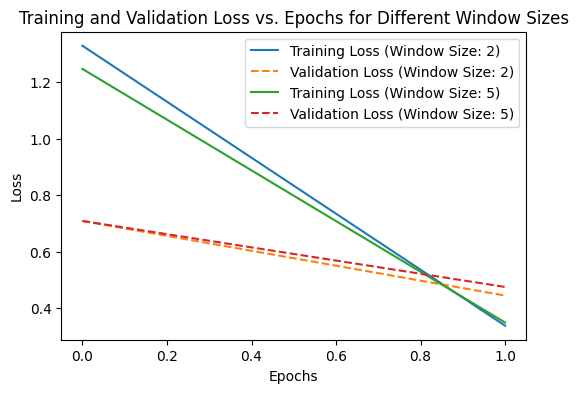

In [12]:
# Plot training and validation loss
plt.figure(figsize=(6, 4))

for window_size, history in histories.items():
    plt.plot(history.history['loss'], label=f'Training Loss (Window Size: {window_size})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (Window Size: {window_size})', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs for Different Window Sizes')
plt.legend()
plt.savefig(f'./Results/training_validation_loss_vs_epochs_J={coupling}.png')
plt.show()

### Plot results

In [13]:
def plot_results(window_size):


    # Define the colors for the custom cyclic colormap
    colors = [
        (1.0, 0.0, 1.0),  # Magenta (255, 0, 255)
        (1.0, 0.0, 0.0),  # Red (255, 0, 0)
        (1.0, 1.0, 0.0),  # Yellow (255, 255, 0)
        (0.0, 1.0, 0.0),  # Green (0, 255, 0)
        (0.0, 1.0, 1.0),  # Cyan (0, 255, 255)
        (0.0, 0.0, 1.0),  # Blue (0, 0, 255)
        (1.0, 0.0, 1.0)   # Magenta (255, 0, 255)
    ]

    # Create the custom cyclic colormap
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)



    fig = plt.figure()
    # _________________________________________________________
    ax_1 = plt.subplot(3, 4, (1, 4))
    # Read the input data
    with open(f"./Results/J={coupling}_window{window_size}_actual.txt") as textFile:  # ./Results/J={coupling}_actual.txt
        lines = [line.split() for line in textFile]

    lines = np.array(lines, dtype=float).transpose()  # Convert to numpy array and transpose
    print(np.min(lines))
    print(np.max(lines))
    # plot
    vmin = -np.pi
    vmax = np.pi
    plt.imshow(lines, cmap=custom_cmap, aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(ticks=[vmin, 0, vmax])
    cbar.ax.set_yticklabels(['-π', '0', 'π'])

    plt.title(f'LSTM (window {window_size})', fontsize=10)
    # plot
    # Customize tick parameters
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=10,
                    labelcolor='#262626')
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False, labelsize=10,
                    labelcolor='#262626')
    # Reverse the y-axis direction
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    # Set x and y limits
    plt.xlim(0, len(lines[0]))
    plt.ylim(0, 60)
    # Set labels
    plt.ylabel('Node (i)', fontsize=10, labelpad=10)
    plt.xlabel('Time (s)', fontsize=10)
    # _________________________________________________________

    ax_2 = plt.subplot(3, 4, (5, 8))

    # Read the input data
    with open(f"./Results/J={coupling}_window{window_size}_predicted.txt") as textFile:
        lines2 = [line.split() for line in textFile]
    lines2 = np.array(lines2, dtype=float).transpose()  # Convert to numpy array and transpose

    # Subtract 2*pi from values greater than pi
    lines2 = np.where(lines2 > np.pi, lines2 - 2 * np.pi, lines2)

    # Add 2*pi to values less than -pi
    lines2 = np.where(lines2 < -np.pi, lines2 + 2 * np.pi, lines2)

    print(np.min(lines2))
    print(np.max(lines2))
    # plot
    vmin = -np.pi
    vmax = np.pi
    plt.imshow(lines2, cmap=custom_cmap, aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(ticks=[vmin, 0, vmax])
    cbar.ax.set_yticklabels(['-π', '0', 'π'])

    # plot
    # Customize tick parameters
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=10,
                    labelcolor='#262626')
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False, labelsize=10,
                    labelcolor='#262626')
    # Reverse the y-axis direction
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    # Set x and y limits
    plt.xlim(0, len(lines2[0]))
    plt.ylim(0, 60)
    # Set labels
    plt.ylabel('Node (i)', fontsize=10, labelpad=10)
    plt.xlabel('Time (s)', fontsize=10)
    # _________________________________________________________


    s = (len(lines[:, 0]),len(lines[0, :]))
    lines3 = np.zeros(s)
    ax_3 = plt.subplot(3, 4, (9, 12))
    for i in range(len(lines[:, 0])):
        for j in range(len(lines[0, :])):
            #lines3[i][j] = np.cos(lines2[i][j] - lines[i][j])
            lines3[i][j] = lines2[i][j] - lines[i][j]
            if lines3[i][j] > np.pi:
                lines3[i][j] =lines3[i][j] - 2 * np.pi
            elif lines3[i][j] < -np.pi:
                lines3[i][j] =lines3[i][j] + 2 * np.pi

    print(np.min(lines3))
    print(np.max(lines3))
    # plot
    vmin = np.min(lines3)
    vmax = np.max(lines3)
    plt.imshow(lines3, cmap=custom_cmap, aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)  
    cbar = plt.colorbar(ticks=[vmin, 0, vmax])
    cbar.ax.set_yticklabels(['-π', '0', 'π'])
    # Customize tick parameters
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=10,
                    labelcolor='#262626')
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False, labelsize=10,
                    labelcolor='#262626')
    # Reverse the y-axis direction
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    # Set x and y limits
    plt.xlim(0, len(lines3[0]))
    print(len(lines3[0]))
    plt.ylim(0, 60)
    # Set labels
    plt.ylabel('Node (i)', fontsize=10, labelpad=10)
    plt.xlabel('Time (s)', fontsize=10)

    # Save the figure as a .png file
    plt.subplots_adjust(top=0.97, bottom=0.08, hspace=0.3, wspace=0.44)

    plt.gcf().set_size_inches(12, 3)
    plt.savefig(f'./Results/result_J={coupling}_window{window_size}.png' , dpi=300)
    #plt.savefig(f'./Results/result_J={coupling}_window{window_size}.pdf')


-3.14158
3.14158
-3.141564
3.141574
-3.1415214000000002
3.140037597179586
10000
-3.14158
3.14158
-3.141481
3.141582
-3.139006567179586
3.14103534
9997


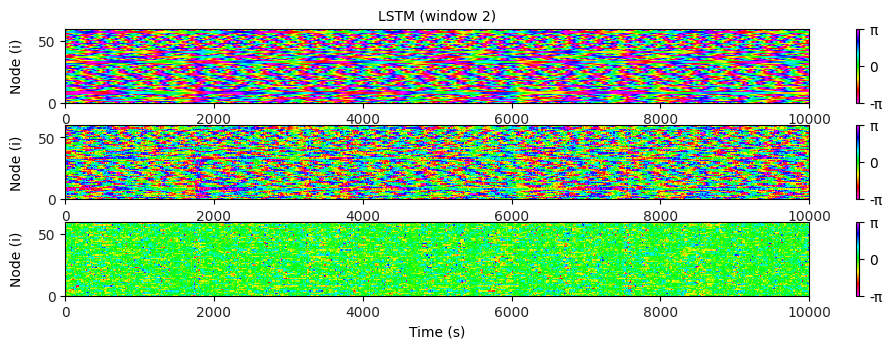

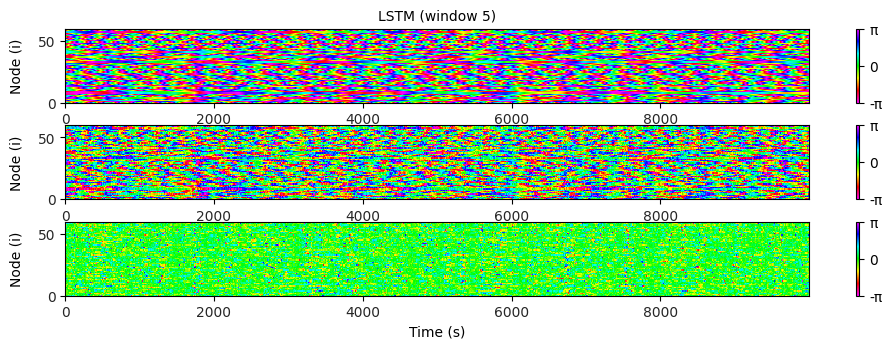

In [14]:
for window_size in window_sizes:
    plot_results(window_size)